In [6]:
import numpy as np
import matplotlib

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
from scipy import special as sp
from scipy import fftpack
import plasmapy.mathematics
import scipy.optimize as op
from scipy import integrate
%config InlineBackend.figure_format = 'svg'
#%matplotlib notebook

In [12]:
tem = 1
L = 15
vmax = 5  # 10 * np.sqrt(tem)
nx = 101
nv = 1001
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V, X = np.meshgrid(v, x)
max_steps = 100000
data_steps = 10000
data_num = int(max_steps/data_steps)
dt=0.02
uae = 0.05

path = '../data/'

m=1
n=1
q=1
v_th = np.sqrt(2*tem)
l_D = np.sqrt( tem) # $\lambda_D^2$
w_pe = 1
print(data_num)

10


## nonlinear Landau damping to a bgk mode

In [13]:
k = 2*np.pi/L
def eq4PDRM(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta = wc / k /v_th
    r = 1 + 1 / k**2 / l_D**2 * ( 1 + zeta*plasmapy.mathematics.plasma_dispersion_func(zeta) )
    return [r.real,r.imag]
#kvec = np.arange(.1,1.2,0.1)
print("k = ",k)
s=op.root(lambda w:eq4PDRM(w,k),[1,0.1])
v_p = s.x[0]/k
print("w_r = ",s.x[0])
print("w_i = ",s.x[1])
print("v_p = ",v_p)
print("rt = ", abs(s.x[1]/np.sqrt(uae)))
print('ltime',2*np.pi/k/dv)
print("rtime", dt*max_steps)

k =  0.41887902047863906
w_r =  1.3096062176484635
w_i =  -0.08039781657437421
v_p =  3.1264545456395028
rt =  0.35954996620572005
ltime 1500.0
rtime 2000.0


In [14]:
progesses = np.arange(0,data_num,1)

f = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)

In [15]:
dataet = np.loadtxt(os.path.join(path, "tot_energy"))
dataep = np.loadtxt(os.path.join(path, "pot_energy"))
dataek = np.loadtxt(os.path.join(path, "kin_energy"))

t = np.linspace(0, max_steps, max_steps)

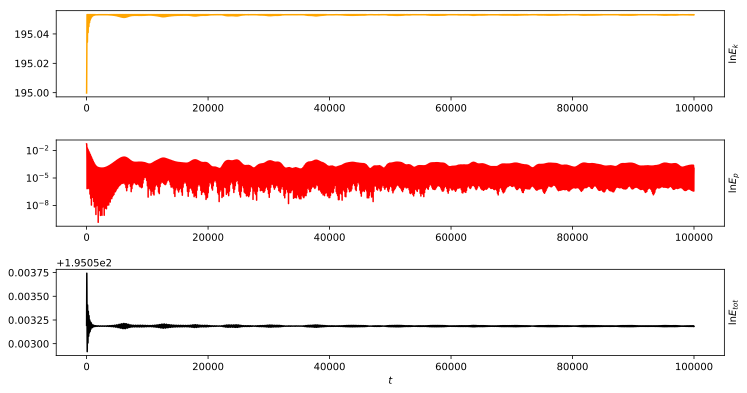

In [16]:
fig = plt.figure(figsize=(12, 6))

ax1 = plt.subplot2grid((3, 1), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$\ln E_k$')
#ax1.set_yscale('log')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 1), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$\ln E_p$')
ax2.set_yscale('log')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 1), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$\ln E_{tot}$')
#ax3.set_yscale('log')
ax3.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()

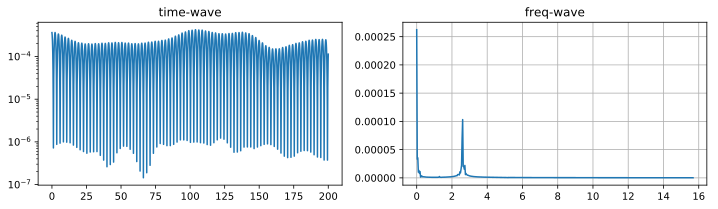

In [18]:
wave_start = max_steps-10000
wave_end = max_steps
wave_steps = wave_end - wave_start

t = np.linspace(0,wave_steps*dt,wave_steps)
yy = dataep[wave_start:wave_end]
n = wave_steps

def PlotWaveFreq(t,y):
    n = t.size
    y_k = fftpack.fft(y)
    x_k = fftpack.fftfreq(len(y_k),dt)

    plt.figure(figsize=(12,3))
    ax1 = plt.subplot(121)
    ax1.plot(t,y)
    ax1.set_yscale('log')
    ax1.set_title('time-wave')
    ax2 = plt.subplot(122)
    ax2.plot(2*np.pi*x_k[0:n//20],2.0*np.abs(y_k[0:n//20]/n))
    ax2.set_title('freq-wave')
    ax2.grid()
    plt.show()

PlotWaveFreq(t,yy)

### 初始分布函数fx fv

In [19]:
def fm(v, t):
    r = np.sqrt(1./(2.*np.pi*t))*np.exp(-v**2/(2*t))
    return r
def fk(v, t, kappa):
    if(kappa == 0):
        r = fm(v, t)
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r
def ue(x):
    r = 1.+uae*np.cos(2.*np.pi*x/L)
    return r
def ui(x):
    r = 1.+uai*np.cos(2.*np.pi*x/L)
    return r

In [20]:
fx0 = np.sum(f[0][:,0:nv-1],axis=1)*dv
fv0 = np.sum(f[0][0:nx-1,:],axis=0)*dx

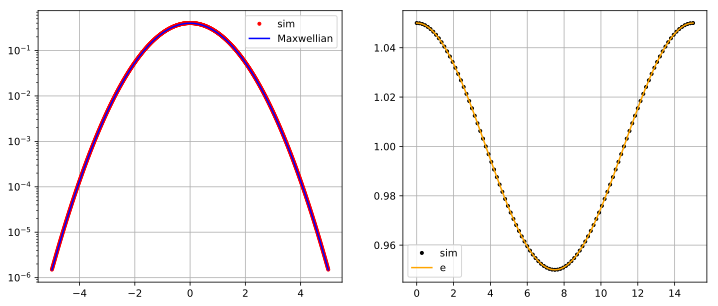

In [21]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(v,fv0,'.',color='r',label='sim')
ax1.plot(v,fm(v,tem),color='blue',label='Maxwellian')
ax1.set_yscale('log')

ax2.plot(x,fx0,'.',color='black',label='sim')
ax2.plot(x,ue(x),color='orange',label='e')

ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

### 末态分布函数

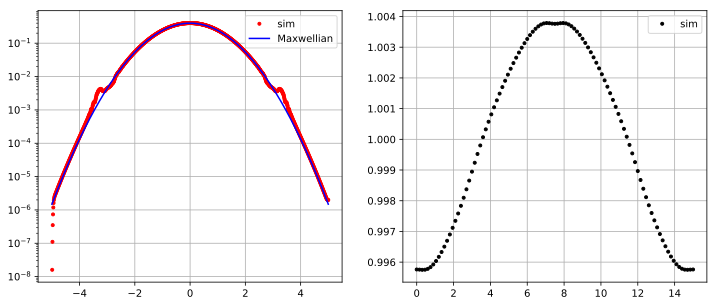

In [22]:
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(v,fv,'.',color='r',label='sim')
ax1.plot(v,fm(v,tem),color='blue',label='Maxwellian')
ax1.set_yscale('log')

ax2.plot(x,fx,'.',color='black',label='sim')

ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

## 中间态相图

In [34]:
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
Z = f[1]
ax1.contourf(X,V,Z,levels=50)
v_plot_mean=v_p
v_plot_shift=0.5
v_plot_min = int((v_plot_mean-v_plot_shift+vmax)/dv)
v_plot_max = int((v_plot_mean+v_plot_shift+vmax)/dv)
#ax2.contourf(X[:,v_plot_min:v_plot_max],V[:,v_plot_min:v_plot_max],Z[:,v_plot_min:v_plot_max],levels=50)
ax2.imshow(Z[:,v_plot_min:v_plot_max].T,interpolation='spline36',aspect='auto')
plt.show()

## 末态相图

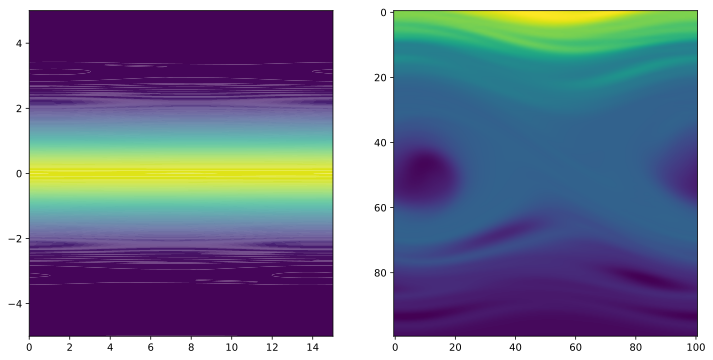

In [33]:
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
Z = f[data_num-1]
ax1.contourf(X,V,Z,levels=200)
v_plot_mean=v_p
v_plot_shift=0.5
v_plot_min = int((v_plot_mean-v_plot_shift+vmax)/dv)
v_plot_max = int((v_plot_mean+v_plot_shift+vmax)/dv)
ax2.imshow(Z[:,v_plot_min:v_plot_max].T,interpolation='spline36',aspect='auto')
#ax2.contourf(X[:,v_plot_min:v_plot_max],V[:,v_plot_min:v_plot_max],Z[:,v_plot_min:v_plot_max],levels=100)
plt.show()